In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',10)
%matplotlib inline

In [2]:
pip install cassandra-driver --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 45.0 MB/s eta 0:00:00


# Read Dataset

In [3]:
# specifying client_id and client_secret to connect to cassandra database
client_id ="tyljnJccJsMUJWJZULcWFcwE"
client_secret="d383FAiT+o-b65G0O-+6revb1zjKE6,v7cMQ,Q_AQQMWW_wCKUa7nXlZ4tuMLradeHWHbgur48bx3j7kQgGC27cH_RI_YTL-.iFaqKLboO68hAZyXZutEMsOdBw_XF9C"
token="AstraCS:tyljnJccJsMUJWJZULcWFcwE:4a2d5e3ac085afbba9ae136b7ec042a2805760bc110007905c0c50543b57d560"


In [4]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

cloud_config = {
    'secure_connect_bundle': 'secure-connect-census-data.zip'
}
auth_provider = PlainTextAuthProvider(client_id,client_secret)

# Create a Cluster with the USE_BETA flag set to True
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()


ERROR:cassandra.connection:Closing connection <AsyncoreConnection(133131766067120) 08623250-387d-431a-8685-62bf0d954e25-us-east1.db.astra.datastax.com:29042:df4dfc2a-e9b9-4d58-b1e1-24cb196521fc> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


In [5]:
# Set the keyspace using the USE statement
session.execute("USE income_prediction")

# Execute a query in the selected keyspace
query = "SELECT * FROM census"
result = session.execute(query)

# Process the query result
for row in result:
    print(row)

Streaming output truncated to the last 5000 lines.
Row(age=22, fnlwgt=123440, sex=' Male', capital_gain=0, capital_loss=0, country=' United-States', education=' Some-college', education_num=10, hours_per_week=48, marital_status=' Never-married', occupation=' Craft-repair', race=' White', relationship=' Not-in-family', salary=' <=50K', workclass=' Self-emp-not-inc')
Row(age=33, fnlwgt=428271, sex=' Female', capital_gain=0, capital_loss=0, country=' United-States', education=' HS-grad', education_num=9, hours_per_week=35, marital_status=' Divorced', occupation=' Adm-clerical', race=' Black', relationship=' Unmarried', salary=' <=50K', workclass=' Federal-gov')
Row(age=29, fnlwgt=206351, sex=' Male', capital_gain=0, capital_loss=0, country=' United-States', education=' Bachelors', education_num=13, hours_per_week=40, marital_status=' Never-married', occupation=' Prof-specialty', race=' White', relationship=' Not-in-family', salary=' <=50K', workclass=' Private')
Row(age=46, fnlwgt=58683, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Row(age=29, fnlwgt=239753, sex=' Female', capital_gain=0, capital_loss=2057, country=' United-States', education=' HS-grad', education_num=9, hours_per_week=20, marital_status=' Married-civ-spouse', occupation=' Adm-clerical', race=' White', relationship=' Wife', salary=' <=50K', workclass=' Private')
Row(age=48, fnlwgt=189762, sex=' Male', capital_gain=0, capital_loss=0, country=' United-States', education=' HS-grad', education_num=9, hours_per_week=40, marital_status=' Married-civ-spouse', occupation=' Craft-repair', race=' White', relationship=' Husband', salary=' >50K', workclass=' Local-gov')
Row(age=49, fnlwgt=173115, sex=' Male', capital_gain=4416, capital_loss=0, country=' United-States', education=' 10th', education_num=6, hours_per_week=99, marital_status=' Separated', occupation=' Exec-managerial', race=' Black', relationship=' Not-in-family', salary=' <=50K', workclass=' Private')
Row(age=23, fnlwgt=164574, sex=' Male', cap

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
df = pd.DataFrame(list(session.execute("SELECT * FROM census")))
df.head()

,age,fnlwgt,sex,capital_gain,capital_loss,...,occupation,race,relationship,salary,workclass
0,51,291755,Male,0,0,...,Exec-managerial,White,Husband,<=50K,Self-emp-not-inc
1,81,114670,Female,2062,0,...,Priv-house-serv,Black,Not-in-family,<=50K,Private
2,17,241021,Female,0,0,...,?,Other,Own-child,<=50K,?
3,30,323054,Male,0,0,...,Other-service,Amer-Indian-Eskimo,Not-in-family,<=50K,Private
4,24,241857,Female,0,0,...,Adm-clerical,Black,Not-in-family,<=50K,Private


In [7]:
df.shape

(29166, 15)

# Glimpse of Data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29166 entries, 0 to 29165
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             29166 non-null  int64 
 1   fnlwgt          29166 non-null  int64 
 2   sex             29166 non-null  object
 3   capital_gain    29166 non-null  int64 
 4   capital_loss    29166 non-null  int64 
 5   country         29166 non-null  object
 6   education       29166 non-null  object
 7   education_num   29166 non-null  int64 
 8   hours_per_week  29166 non-null  int64 
 9   marital_status  29166 non-null  object
 10  occupation      29166 non-null  object
 11  race            29166 non-null  object
 12  relationship    29166 non-null  object
 13  salary          29166 non-null  object
 14  workclass       29166 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.3+ MB


In [9]:
df.describe()

,age,fnlwgt,capital_gain,capital_loss,education_num,hours_per_week
count,29166.000000,2.916600e+04,29166.000000,29166.000000,29166.000000,29166.000000
mean,38.805973,1.915263e+05,1051.210245,83.883734,10.041178,40.312247
std,13.843893,1.075392e+05,7314.910669,395.583264,2.580356,12.431054
min,17.000000,1.228500e+04,0.000000,0.000000,1.000000,1.000000
25%,28.000000,1.176815e+05,0.000000,0.000000,9.000000,40.000000
50%,37.000000,1.797330e+05,0.000000,0.000000,10.000000,40.000000
75%,48.000000,2.408400e+05,0.000000,0.000000,12.000000,45.000000
max,90.000000,1.484705e+06,99999.000000,4356.000000,16.000000,99.000000


In [10]:
df.isnull().sum()

age               0
fnlwgt            0
sex               0
capital_gain      0
capital_loss      0
country           0
education         0
education_num     0
hours_per_week    0
marital_status    0
occupation        0
race              0
relationship      0
salary            0
workclass         0
dtype: int64

There are no Missing Values

In [11]:
df.duplicated().sum()

0

There are no duplicate rows

Check the datatypes of each rows

In [12]:
df.dtypes

age                int64
fnlwgt             int64
sex               object
capital_gain       int64
capital_loss       int64
country           object
education         object
education_num      int64
hours_per_week     int64
marital_status    object
occupation        object
race              object
relationship      object
salary            object
workclass         object
dtype: object

We have noticed above dataset have null values in the form of ' ?'

In [13]:
# Checking the counts of label categories
df.isin([' ?']).sum()

age                  0
fnlwgt               0
sex                  0
capital_gain         0
capital_loss         0
country            514
education            0
education_num        0
hours_per_week       0
marital_status       0
occupation        1712
race                 0
relationship         0
salary               0
workclass         1706
dtype: int64

In [14]:
df = df.replace(' ?', np.nan)

In [15]:
df.isin([' ?']).sum()

age               0
fnlwgt            0
sex               0
capital_gain      0
capital_loss      0
country           0
education         0
education_num     0
hours_per_week    0
marital_status    0
occupation        0
race              0
relationship      0
salary            0
workclass         0
dtype: int64

In [16]:
df.isnull().sum()

age                  0
fnlwgt               0
sex                  0
capital_gain         0
capital_loss         0
country            514
education            0
education_num        0
hours_per_week       0
marital_status       0
occupation        1712
race                 0
relationship         0
salary               0
workclass         1706
dtype: int64

In [17]:
#remove null values
df=df.dropna()

In [18]:
df.isna().sum()

age               0
fnlwgt            0
sex               0
capital_gain      0
capital_loss      0
country           0
education         0
education_num     0
hours_per_week    0
marital_status    0
occupation        0
race              0
relationship      0
salary            0
workclass         0
dtype: int64

# Visualization of Data

Based on Sex/Gender

In [19]:
df.columns

Index(['age', 'fnlwgt', 'sex', 'capital_gain', 'capital_loss', 'country',
       'education', 'education_num', 'hours_per_week', 'marital_status',
       'occupation', 'race', 'relationship', 'salary', 'workclass'],
      dtype='object')

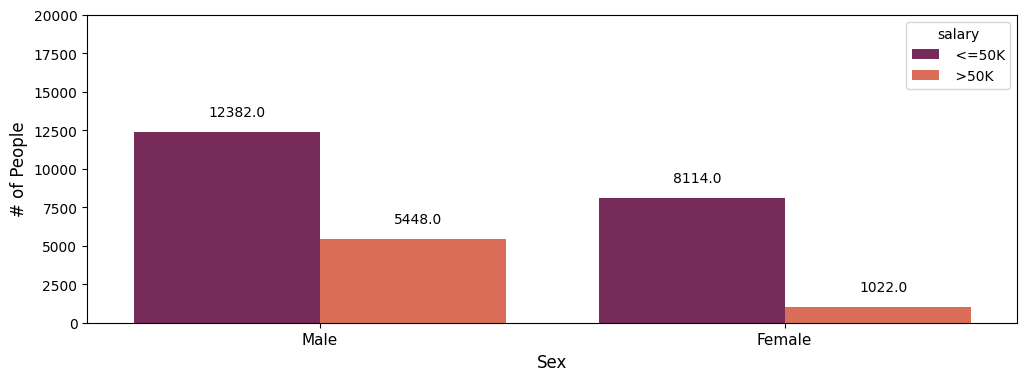

In [20]:
import seaborn as sns
plt.figure(figsize=(12,4))
ax = sns.countplot(data = df, x = 'sex', hue="salary", palette = 'rocket')

plt.xlabel("Sex", fontsize= 12)
plt.ylabel("# of People", fontsize= 12)
plt.ylim(0,20000)
plt.xticks([0,1],['Male', 'Female'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.16, p.get_height()+1000))

plt.show()

2.Based on Education

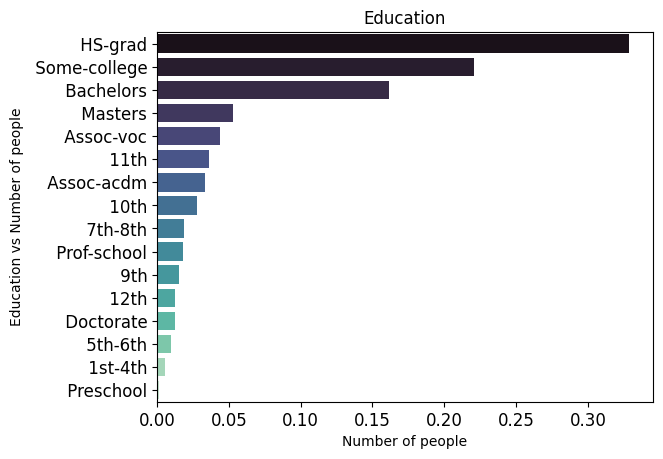

In [21]:
# Count the number of times each education level appears in the DataFrame
edu = df["education"].value_counts(normalize=True)

# Create a bar plot of the distribution of education levels
sns.barplot(x=edu.values, y=edu.index, palette='mako')

# Set the title, x-axis label, and y-axis label
plt.title('Education')
plt.xlabel('Number of people')
plt.ylabel('Education vs Number of people')

# Set the font size for the tick labels
plt.tick_params(labelsize=12)

# Display the plot
plt.show()


3.Based on Marital-Status

In [22]:
df['marital_status'].value_counts()

 Married-civ-spouse       12368
 Never-married             8681
 Divorced                  3893
 Separated                  874
 Widowed                    789
 Married-spouse-absent      342
 Married-AF-spouse           19
Name: marital_status, dtype: int64

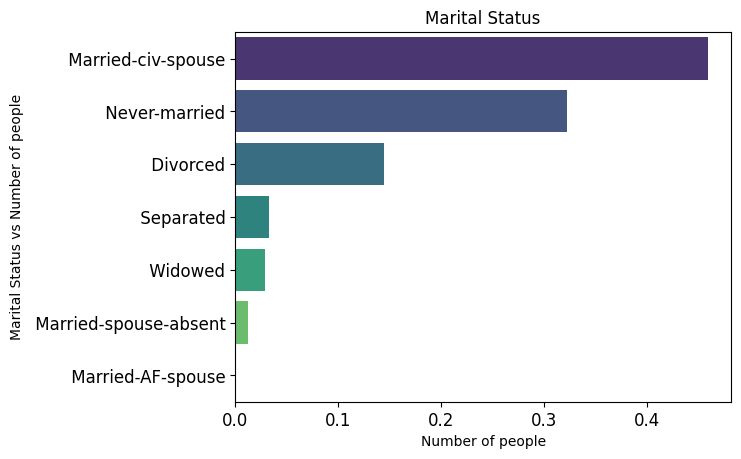

In [23]:
# Calculate the value counts for marital status and normalize them
status = df["marital_status"].value_counts(normalize=True)

# Create a bar plot
sns.barplot(x=status.values, y=status.index, palette='viridis')
plt.title('Marital Status')
plt.xlabel('Number of people')
plt.ylabel('Marital Status vs Number of people')
plt.tick_params(labelsize=12)
plt.show()

4.Based on Age

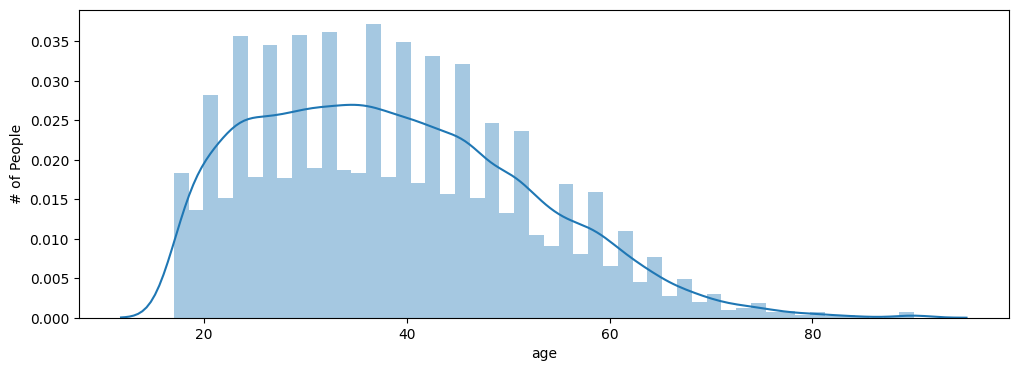

In [24]:
plt.figure(figsize=(12,4))

sns.distplot(df['age'])
plt.ticklabel_format(style='scientific', axis='x') #repressing scientific notation on x
plt.ylabel('# of People')
plt.show()

5.Based on Race

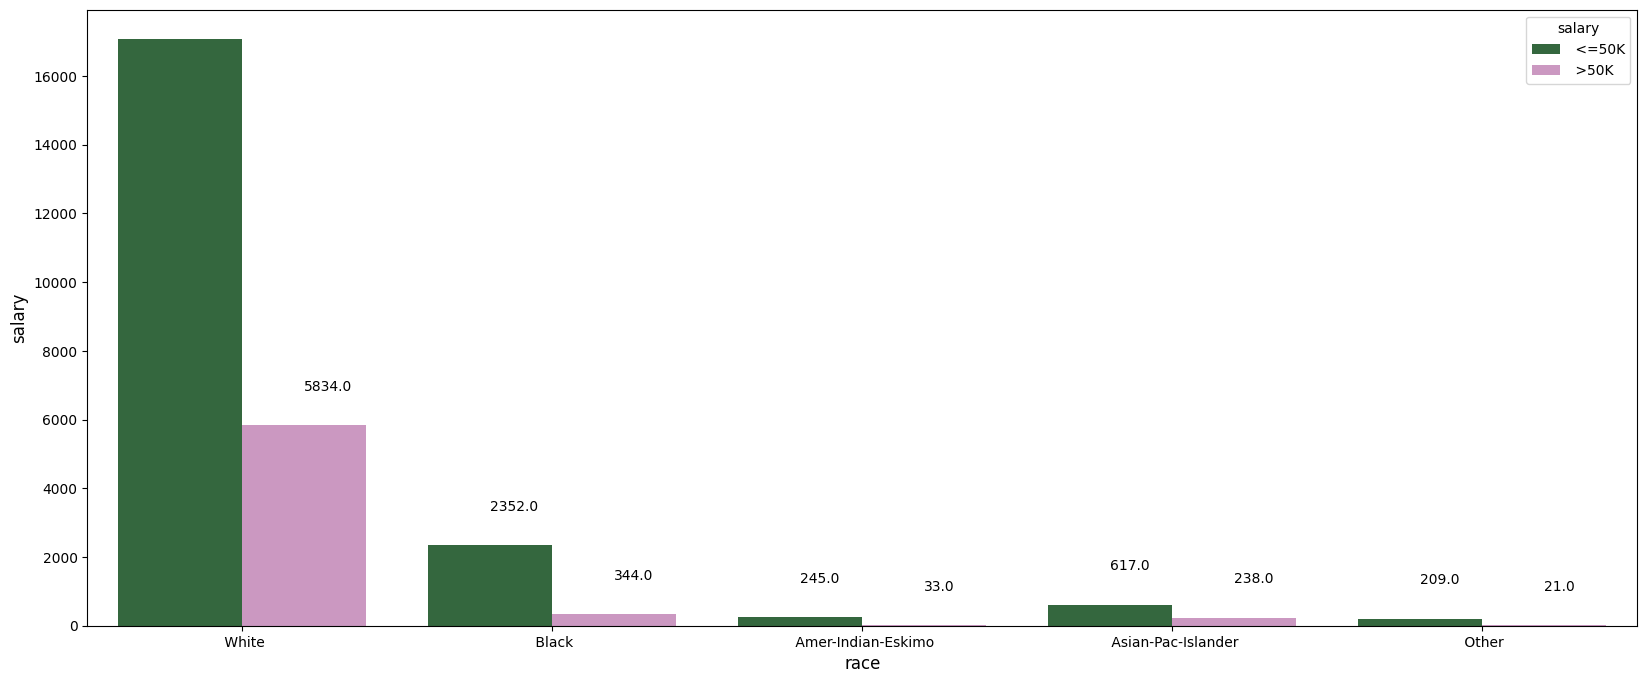

In [25]:
plt.figure(figsize=(20,8))
ax = sns.countplot(data = df, x = 'race', hue="salary", palette = 'cubehelix')

plt.xlabel("race", fontsize= 12)
plt.ylabel("salary", fontsize= 12)


for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.20, p.get_height()+1000))

6.Based on Education

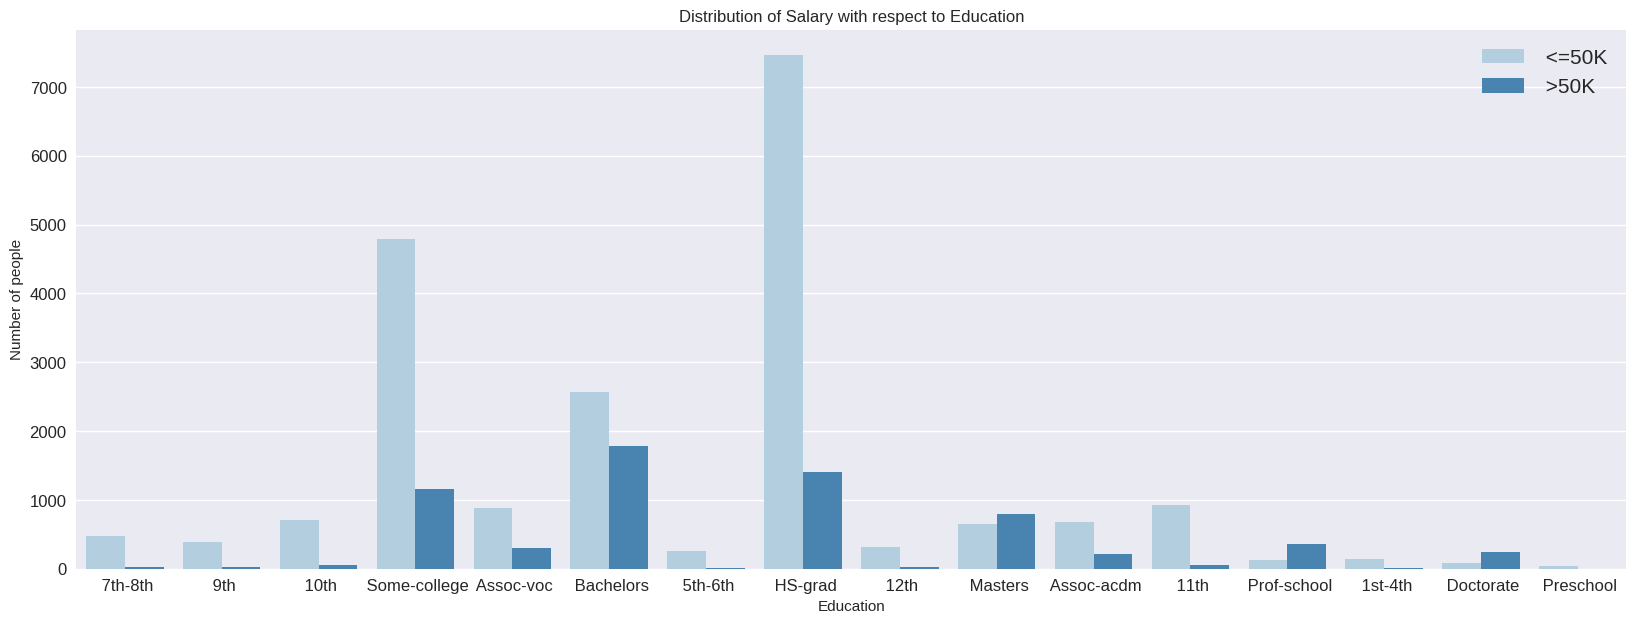

In [26]:

plt.style.use('seaborn')
plt.figure(figsize=(20, 7))

sns.countplot(data=df, x='education', hue='salary', palette='Blues')

plt.title('Distribution of Salary with respect to Education')
plt.xlabel('Education')
plt.ylabel('Number of people')
plt.tick_params(labelsize=12)
plt.legend(loc=1, prop={'size': 15})
plt.show()

7.Based on Marital Status

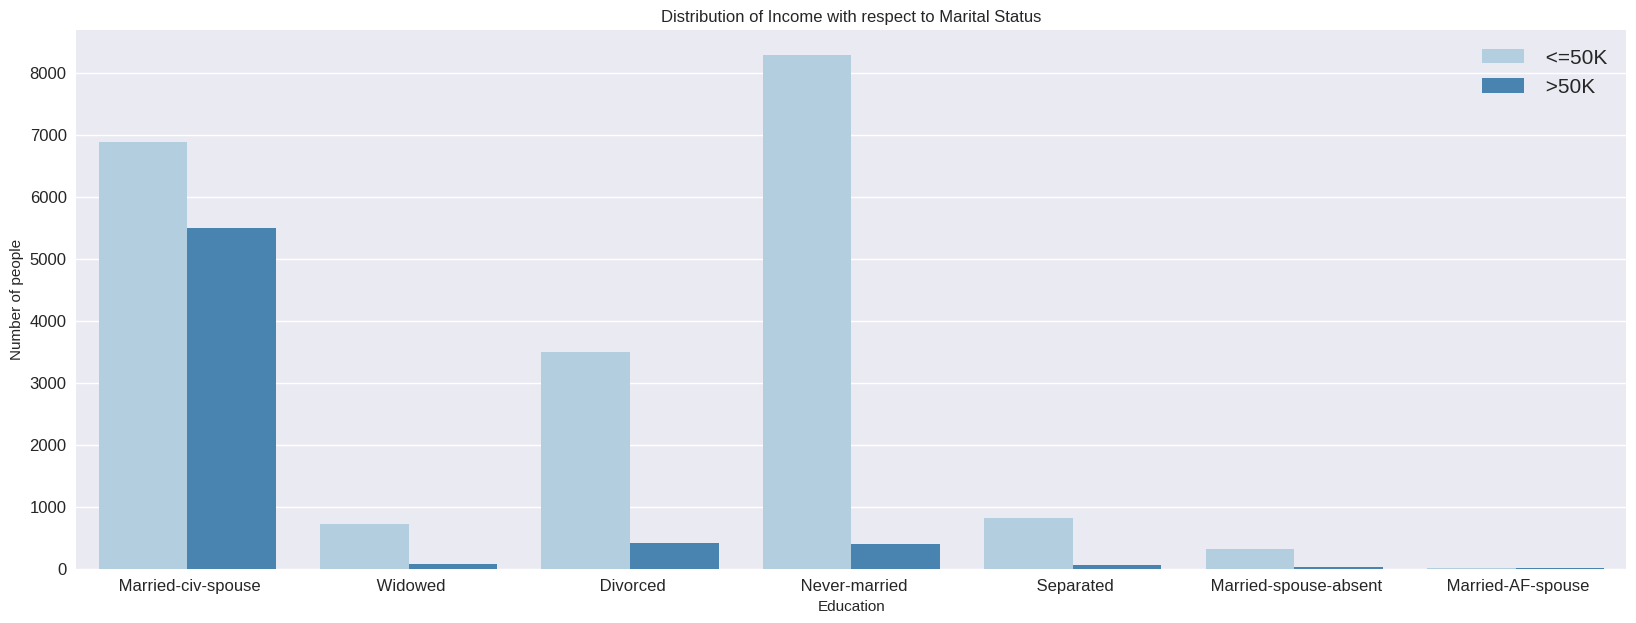

In [27]:

plt.style.use('seaborn')
plt.figure(figsize=(20, 7))

sns.countplot(data=df, x='marital_status', hue='salary', palette='Blues')

plt.title('Distribution of Income with respect to Marital Status')
plt.xlabel('Education')
plt.ylabel('Number of people')
plt.tick_params(labelsize=12)
plt.legend(loc=1, prop={'size': 15})
plt.show()

8.Average Hours per week

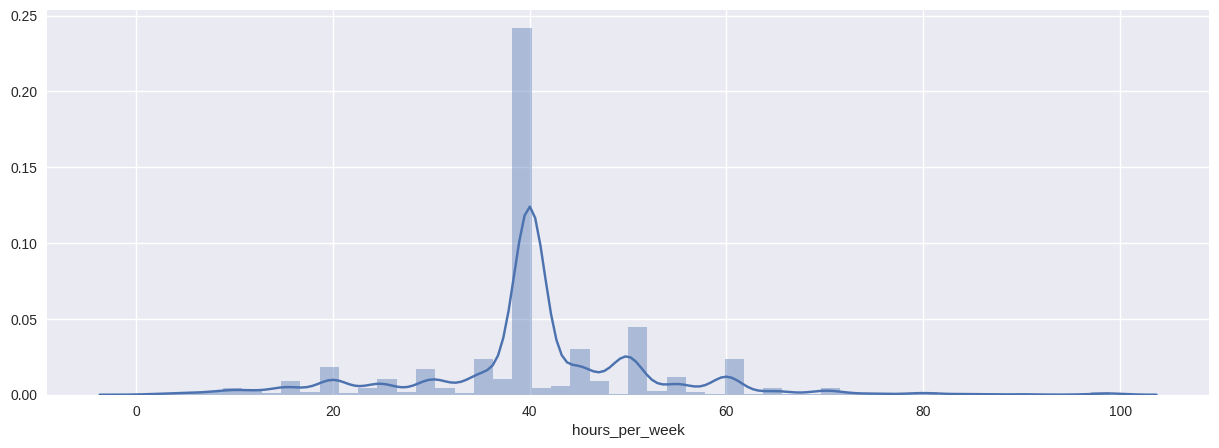

In [28]:
plt.figure(figsize=(15,5))

sns.distplot(df['hours_per_week'])
plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation on x
plt.ylabel('')
plt.show()

9.Occupation

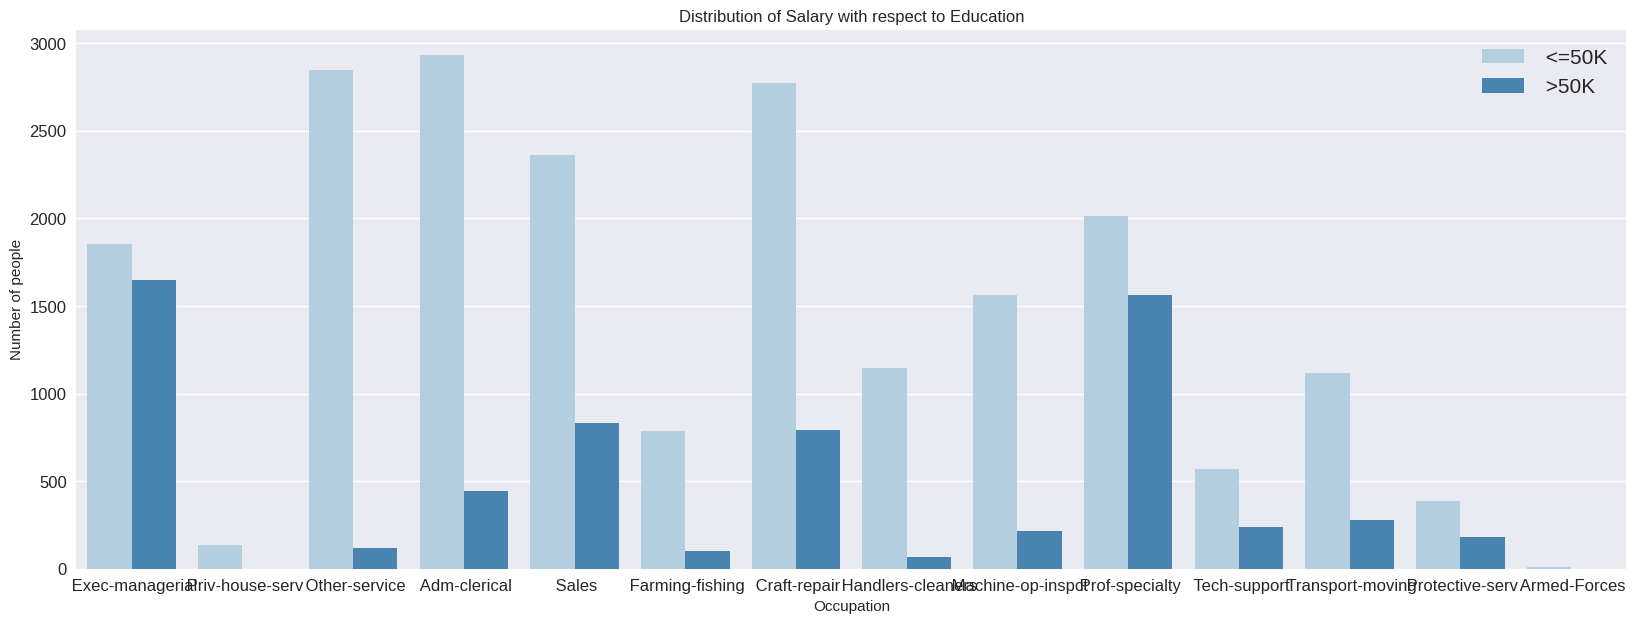

In [29]:
plt.style.use('seaborn')
plt.figure(figsize=(20, 7))

sns.countplot(data=df, x='occupation', hue='salary', palette='Blues')

plt.title('Distribution of Salary with respect to Education')
plt.xlabel('Occupation')
plt.ylabel('Number of people')
plt.tick_params(labelsize=12)
plt.legend(loc=1, prop={'size': 15})
plt.show()

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['salary'] = le.fit_transform(df['salary'])

In [31]:
from sklearn.preprocessing import LabelEncoder
for col in df.columns:
    if df[col].dtypes == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

In [32]:
df.corr()

,age,fnlwgt,sex,capital_gain,capital_loss,...,occupation,race,relationship,salary,workclass
age,1.000000,-0.079682,0.079261,0.082912,0.059519,...,-0.007478,0.030211,-0.244537,0.240886,0.084088
fnlwgt,-0.079682,1.000000,0.030595,0.001964,-0.009100,...,-0.000032,-0.020542,0.008008,-0.007891,-0.035741
sex,0.079261,0.030595,1.000000,0.051086,0.045102,...,0.062410,0.082213,-0.587270,0.214668,0.075339
capital_gain,0.082912,0.001964,0.051086,1.000000,-0.031081,...,0.024144,0.012634,-0.059753,0.222874,0.037650
capital_loss,0.059519,-0.009100,0.045102,-0.031081,1.000000,...,0.018007,0.024020,-0.060355,0.145963,0.010516
country,-0.001756,-0.067300,-0.001298,0.006381,0.011391,...,-0.006003,0.123640,-0.011922,0.023580,0.006900
education,0.000742,-0.025925,-0.030473,0.031177,0.016663,...,-0.037144,0.009815,-0.014239,0.082106,0.018726
education_num,0.045360,-0.045155,0.003578,0.124845,0.076538,...,0.086918,0.028420,-0.089353,0.332212,0.039241
hours_per_week,0.094139,-0.020887,0.227562,0.082866,0.049146,...,0.017070,0.045810,-0.251377,0.227059,0.050013
marital_status,-0.266925,0.031109,-0.114097,-0.041973,-0.030800,...,0.025486,-0.067822,0.167325,-0.187017,-0.033664


In [33]:
X = df.drop("salary",axis=1)
y = df.salary

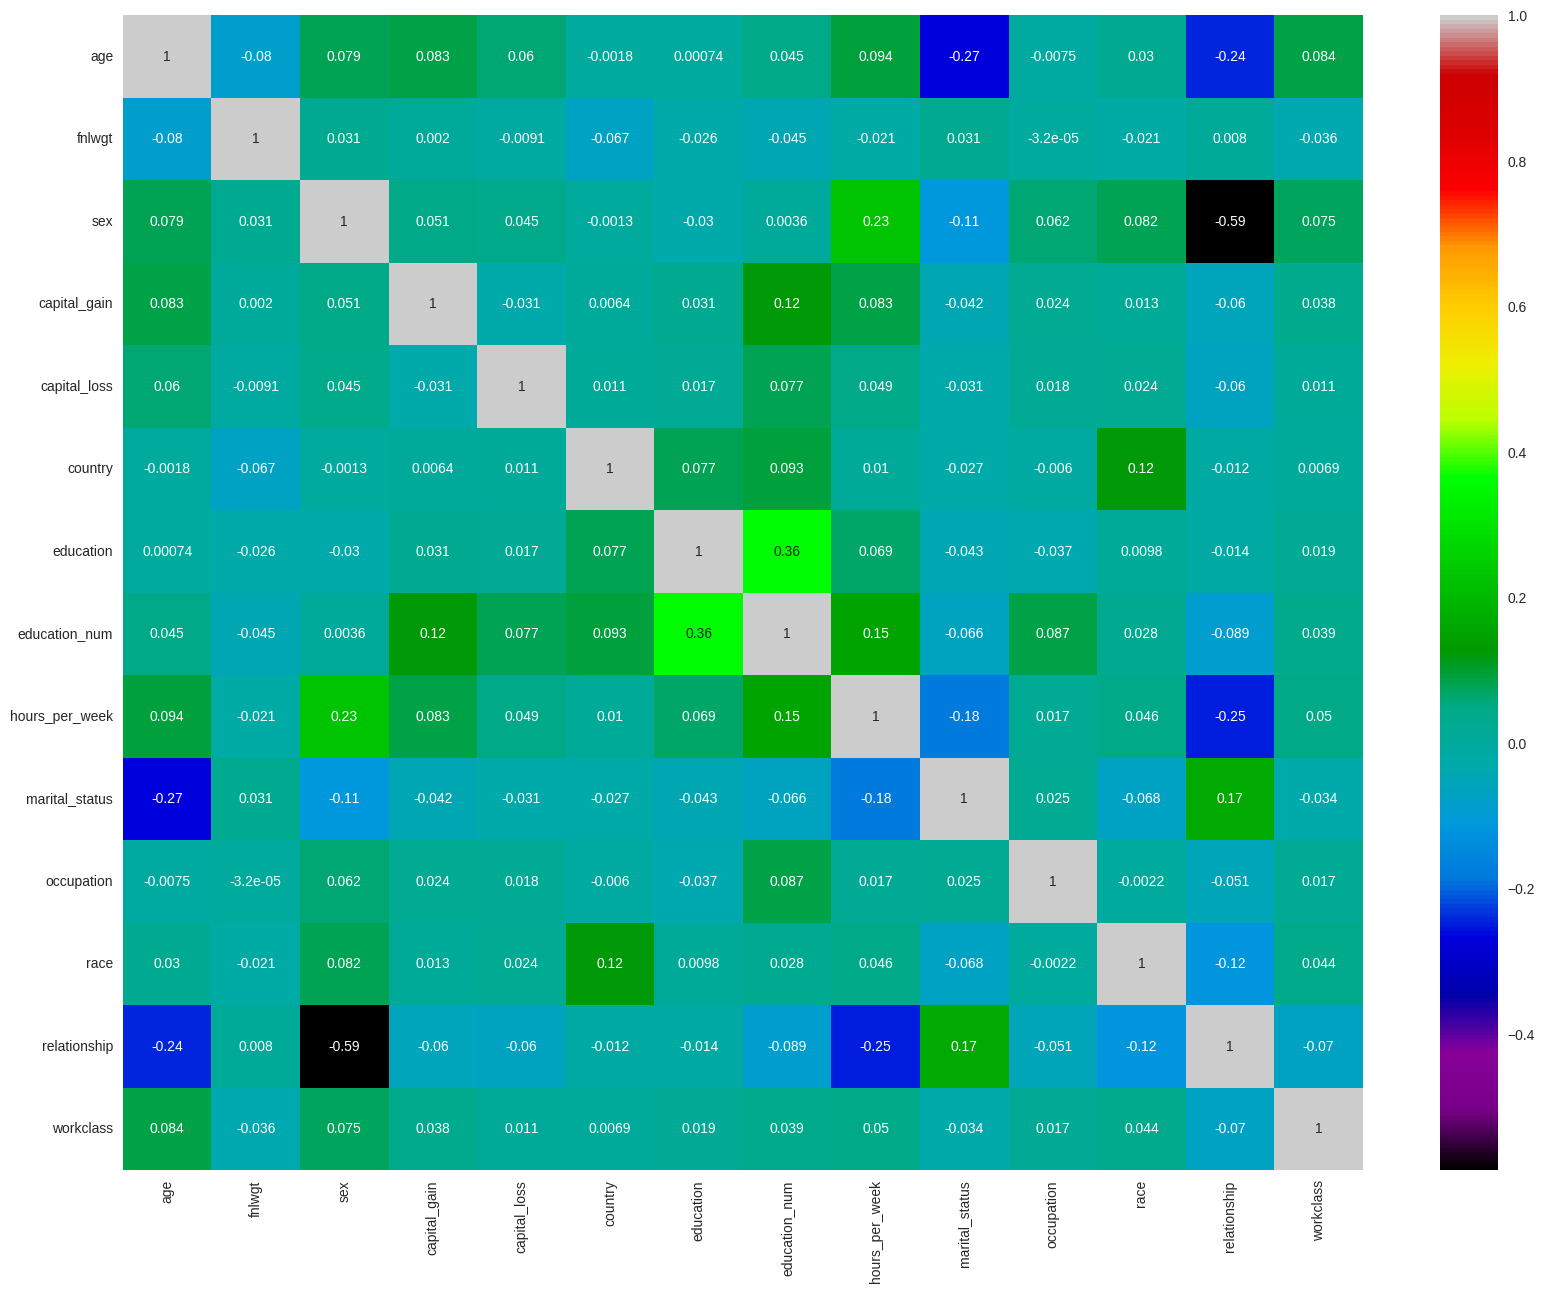

In [34]:
plt.subplots(figsize=(20,15))
sns.heatmap(X.corr(), annot=True, cmap="nipy_spectral")
plt.show()

# Balancing the dataset

In [35]:
from imblearn.over_sampling import RandomOverSampler
random_sampler = RandomOverSampler(random_state=30)

In [36]:
random_sampler.fit(X,y)

RandomOverSampler(random_state=30)

In [37]:
X_new,y_new = random_sampler.fit_resample(X, y)


In [38]:
y_new.value_counts(normalize=True)


0    0.5
1    0.5
Name: salary, dtype: float64

# Modelling

In [39]:
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y_new, test_size=0.30)

In [41]:
clf = DecisionTreeClassifier( max_depth=3)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
# acc_clf = round(clf.score(X_train, y_train) * 100, 2)
acc_clf = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7839486095300049


In [42]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
sgd.score(X_train, y_train)
# acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd = round(metrics.accuracy_score(y_test, y_pred)* 100, 2)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.586518133029761


In [43]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
# acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6527077573589202


In [44]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7510164254350301


In [45]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
# acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6235973328996585


In [46]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
# acc_rf = round(random_forest.score(X_train, y_train) * 100, 2)
acc_rf = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9294194177915108


In [47]:
results = pd.DataFrame({
    'Model': ['Decision Tree','Random Forest','Stochastic Gradient Decent', 'Logistic Regression', 'KNN',
              'Naive Bayes'],
    'Score': [acc_clf,
              acc_rf,acc_sgd,acc_log,acc_knn,acc_gaussian]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)


,Model
Score,
92.94,Random Forest
78.39,Decision Tree
75.10,KNN
65.27,Logistic Regression
62.36,Naive Bayes
58.65,Stochastic Gradient Decent


Picking the Final Model as Random Forest Classifier

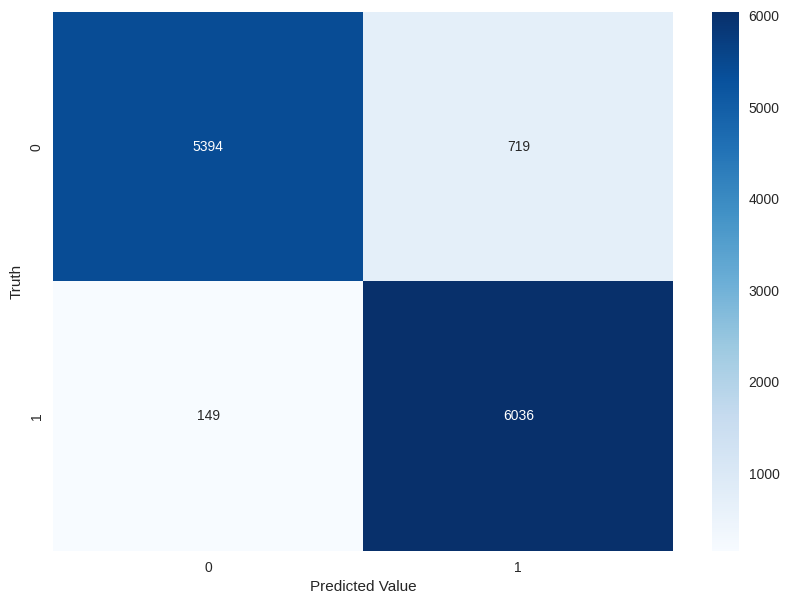

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap="Blues")
plt.xlabel("Predicted Value")
plt.ylabel("Truth")
plt.show()